In [ ]:
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 26kB/s 
     |████████████████████████████████| 4.1MB 39.0MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
     |████████████████████████████████| 276kB 3.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=647e2c78492d4dd146c46e6d9ff469196f3dcd7c740f2dd350ebe2a3afda4990
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import json
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
from detectron2.structures import BoxMode

def get_plant_dicts(img_dir):
    json_file = os.path.join(img_dir, "json.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        #try:
        
        filename = os.path.join(img_dir, v["filename"])
        #print(filename)
        try:
            height, width = cv2.imread(filename).shape[:2]
        except:pass   
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        
        objs = []
        for anno in annos: 
            reg_id =  anno["region_attributes"]   
            try:
              reg_id = reg_id["plant_parts"]
            except KeyError:
              reg_id = " "
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            
            if reg_id == 'Leaf':
                cat_id = 1

            elif reg_id == 'Stem':
                cat_id = 2

            elif reg_id == 'Early_leaf':
                cat_id = 3
            else: cat_id = 0
            
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id":  cat_id 
            }
            
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        #except:
         # pass
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train2", "val"]:
    DatasetCatalog.register("plantP_" + d, lambda d=d: get_plant_dicts("/content/drive/My Drive/mydetectron2/" + d))
    MetadataCatalog.get("plantP_" + d).set(thing_classes=[" ", "Leaf", "Stem", "Early_leaf"])
plant_metadata = MetadataCatalog.get("plantP_train2")
print(plant_metadata)


Metadata(name='plantP_train2', thing_classes=[' ', 'Leaf', 'Stem', 'Early_leaf'])


/content/drive/My Drive/mydetectron2/train2/pic_2020-02-24T23_54_28_384Z_000028.jpg


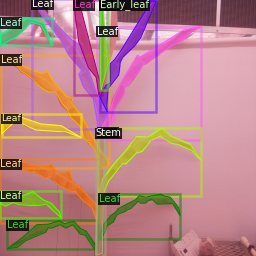

/content/drive/My Drive/mydetectron2/train2/pic_2019-12-16_15_29_54_722892_000883.jpg


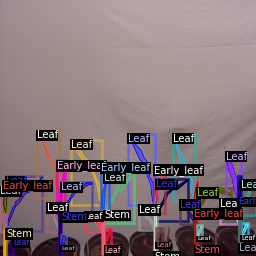

/content/drive/My Drive/mydetectron2/train2/pic_2020-02-24T23_54_28_384Z_000442.jpg


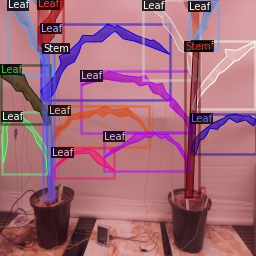

In [ ]:
dataset_dicts = get_plant_dicts(r"/content/drive/My Drive/mydetectron2/train2")
for d in random.sample(dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=plant_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("plantP_train2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 12
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.0005  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (leaf, stem, early leaf)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/30 13:21:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:09, 18.9MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[07/30 13:21:43 d2.engine.train_loop]: Starting training from iteration 0
[07/30 13:23:02 d2.utils.events]:  eta: 1:03:56  iter: 19  total_loss: 4.884  loss_cls: 1.655  loss_box_reg: 0.759  loss_mask: 0.683  loss_rpn_cls: 1.544  loss_rpn_loc: 0.289  time: 3.8551  data_time: 0.1308  lr: 0.000010  max_mem: 8219M
[07/30 13:24:19 d2.utils.events]:  eta: 1:02:45  iter: 39  total_loss: 3.466  loss_cls: 1.419  loss_box_reg: 0.857  loss_mask: 0.649  loss_rpn_cls: 0.348  loss_rpn_loc: 0.236  time: 3.8638  data_time: 0.0815  lr: 0.000020  max_mem: 8219M
[07/30 13:25:37 d2.utils.events]:  eta: 1:01:31  iter: 59  total_loss: 2.852  loss_cls: 1.077  loss_box_reg: 0.855  loss_mask: 0.587  loss_rpn_cls: 0.107  loss_rpn_loc: 0.249  time: 3.8745  data_time: 0.0867  lr: 0.000030  max_mem: 8219M
[07/30 13:26:54 d2.utils.events]:  eta: 1:00:05  iter: 79  total_loss: 2.452  loss_cls: 0.833  loss_box_reg: 0.859  loss_mask: 0.493  loss_rpn_cls: 0.063  loss_rpn_loc: 0.228  time: 3.8736  data_time: 0.0803  lr:

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("plantP_val")
predictor = DefaultPredictor(cfg)

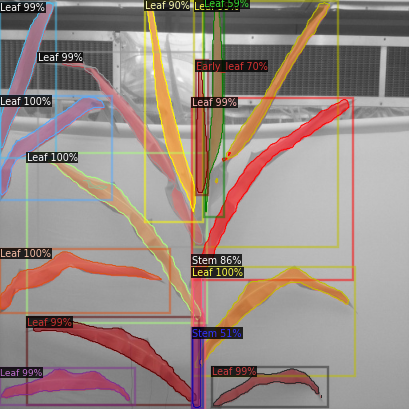

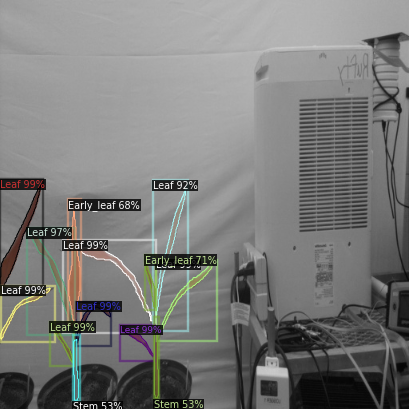

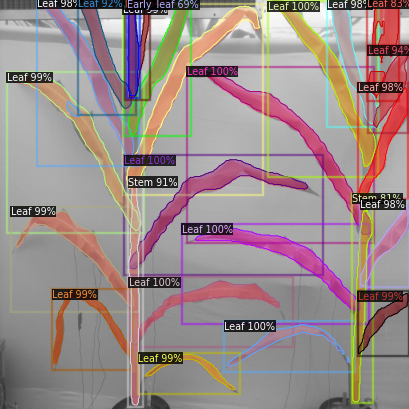

In [ ]:
from detectron2.utils.visualizer import ColorMode
val_dataset =  get_plant_dicts(r"/content/drive/My Drive/mydetectron2/val")
for d in random.sample(val_dataset, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=plant_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("plantP_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "plantP_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[07/30 14:26:56 d2.evaluation.coco_evaluation]: 'plantP_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/30 14:26:56 d2.data.datasets.coco]: Converting annotations of dataset 'plantP_val' to COCO format ...)
[07/30 14:26:57 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/30 14:26:58 d2.data.datasets.coco]: Conversion finished, #images: 95, #annotations: 1394
[07/30 14:26:58 d2.data.datasets.coco]: Caching COCO format annotations at './output/plantP_val_coco_format.json' ...
[07/30 14:26:59 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|            | 11           |    Leaf    | 1069         |    Stem    | 157          |
| Early_leaf | 157          |            |              |            |              |
|   total    | 

OrderedDict([('bbox',
              {'AP': 32.73161328593078,
               'AP- ': 0.0,
               'AP-Early_leaf': 41.207492582675656,
               'AP-Leaf': 70.10114350390126,
               'AP-Stem': 19.617817057146205,
               'AP50': 55.31879506009897,
               'AP75': 33.3579522889148,
               'APl': nan,
               'APm': 37.09485203875882,
               'APs': 31.042547130634752}),
             ('segm',
              {'AP': 22.286460783690075,
               'AP- ': 0.0,
               'AP-Early_leaf': 28.99836335428498,
               'AP-Leaf': 38.7468922856388,
               'AP-Stem': 21.400587494836508,
               'AP50': 53.59023215755069,
               'AP75': 10.374981238323263,
               'APl': nan,
               'APm': 32.400480828911775,
               'APs': 14.584234576895366})])

In [ ]:
test_path = '/content/drive/My Drive/SideCam/Trial004/y20m03d13/'
test_files = os.listdir(test_path)


OSError: ignored

In [ ]:
mask = []
for i, f_name in enumerate(test_files):
    f_name = test_path+f_name
    print(f_name)
    im = cv2.imread(f_name)
    im = cv2.resize(im,(512,512))
    im = cv2.rotate(im, cv2.ROTATE_180)
    #cv2_imshow(im[:, :, :])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                    metadata=plant_metadata, 
                    scale=0.8, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    #print(outputs['instances'])
    mask.append(outputs['instances'].pred_masks[0].cpu().numpy()) #
    if i == 3:
      break

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(mask, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
mask0 = mask[0]
mask1 = mask[1]
adi = np.add(mask0, mask1)
adi = np.add(adi, mask[2])
adi = np.add(adi, mask[3])
plt.imshow(adi)
#print(np.count_nonzero(mask), np.count_nonzero(mask1), np.count_nonzero(mul))
mul = np.multiply(mask[2], mask[3])
plt.imshow(mul)